In [6]:
# imports and settings

import os
import time
import pickle
import warnings
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy

import numpy as np
from numpy import linalg as LA
from numpy import histogram2d

from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks, butter, filtfilt, welch, get_window
from scipy.ndimage import gaussian_filter
from scipy.io import wavfile
from scipy.stats import wasserstein_distance_nd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import utils as ut
%load_ext autoreload
%autoreload 2

# do not show warnings
warnings.filterwarnings("ignore")

print("Imports complete.")

Imports complete.
Settings: height=800, width=1400, font_size=16
Imports complete.


In [2]:

def generate_synthetic_signal(fs, duration, f_shaft=4.0, n_blades=5, cavitation_band=(2000, 5000)):
    """
    Generates a synthetic hydrophone signal with propeller modulation.
    """
    t = np.arange(0, duration, 1/fs)
    
    # 1. The Modulator (The Propeller Physics)
    # Fundamental Shaft Rate: 4 Hz (240 RPM)
    # 5 Blades -> Blade Pass Frequency: 20 Hz
    # f_shaft = 4.0
    # n_blades = 5
    
    # Create a pulse train for blade passes (more realistic than pure sine)
    # A blade passes every 1/(f_shaft * n_blades) seconds
    modulator = np.ones_like(t) * 0.1 # Base noise level
    
    # Add blade modulation harmonics
    # We sum a few harmonics to create a "pulsing" envelope shape
    for h in range(1, 4):
        modulator += (1.0/h) * np.cos(2 * np.pi * (f_shaft * n_blades * h) * t)
        
    # Normalize modulator to be positive (amplitude cannot be negative)
    modulator = (modulator - modulator.min()) / (modulator.max() - modulator.min())
    modulator += 0.2 # Ensure we don't hit true zero (ambient noise floor)

    # 2. The Carrier (Cavitation Noise)
    # Broadband white noise
    carrier = np.random.randn(len(t))
    
    # 3. Apply Modulation (AM)
    modulated_signal = carrier * modulator
    
    # 4. Bandpass the synthetic source to simulate propagation/receiver response
    # We assume the cavitation is loudest in a specific band
    sos = signal.butter(4, cavitation_band, btype='bandpass', fs=fs, output='sos')
    source_signal = signal.sosfilt(sos, modulated_signal)
    
    # 5. Add Ocean Background Noise (Unmodulated)
    background_noise = 0.5 * np.random.randn(len(t))
    
    return t, source_signal + background_noise

In [32]:

def robust_demon_processor(data, fs, passband=(2000, 10000), decimation_factor=None, welch_nperseg=4096, welch_hop=0.5):
    """
    Performs DEMON analysis on a raw acoustic signal.
    
    Args:
        data: The time-series array.
        fs: Sampling frequency.
        passband: Tuple (low, high) for the cavitation band filter.
        decimation_factor: Downsampling factor for the envelope (optimization).
        
    Returns:
        freqs: Frequency array for the spectrum.
        psd: Power Spectral Density of the envelope.
    """
    
    # --- Step 1: Bandpass Filtering ---
    # Isolate the high-frequency cavitation noise
    sos = signal.butter(8, passband, btype='bandpass', fs=fs, output='sos')
    filtered_data = signal.sosfilt(sos, data)
    
    # --- Step 2: Envelope Detection (Demodulation) ---
    # We use the Hilbert transform to get the analytic signal.
    # The magnitude of the analytic signal is the envelope.
    analytic_signal = signal.hilbert(filtered_data)
    envelope = np.abs(analytic_signal)
    
    # --- Step 3: DC Blocking ---
    # Remove the mean to eliminate the huge DC spike at 0Hz
    envelope = envelope - np.mean(envelope)
    
    # --- Step 4: Decimation (Optional but recommended) ---
    # We are looking for low freqs (0-100Hz) inside a high freq signal (20kHz).
    # We can downsample the envelope to save processing time and zoom in.
    # Apply a low-pass anti-aliasing filter before decimating.
    if decimation_factor is not None:
            envelope = signal.decimate(envelope, decimation_factor)
            fs = fs / decimation_factor
    
    # --- Step 5: Spectral Analysis (Welch's Method) ---
    # Welch's method averages periodograms to reduce noise variance.
    # nperseg determines frequency resolution.
    # if len(envelope) < welch_nperseg:
    #     welch_nperseg = len(envelope)
        
    # freqs, psd = signal.welch(
    #     envelope, 
    #     fs=fs, 
    #     nperseg=welch_nperseg, 
    #     window='hann', 
    #     noverlap=int(welch_nperseg * welch_hop)
    # )
    # return freqs, psd

    # y2 = np.abs(np.fft.fftshift(np.fft.fft(envelope)))
    # Faxis = np.linspace(-fs/2, fs/2, len(y2))
    # pos = np.where((Faxis > 2) & (Faxis < passband[0]/2))
    # demon = y2[pos]
    # return Faxis[pos], demon

    F, T, Sxx, _ = ut.calc_spectrogram(envelope, fs, nperseg=welch_nperseg, percent_overlap=welch_hop, window='hanning')
    pxx = ut.calc_welch_from_spectrogram(Sxx)
    return F, pxx


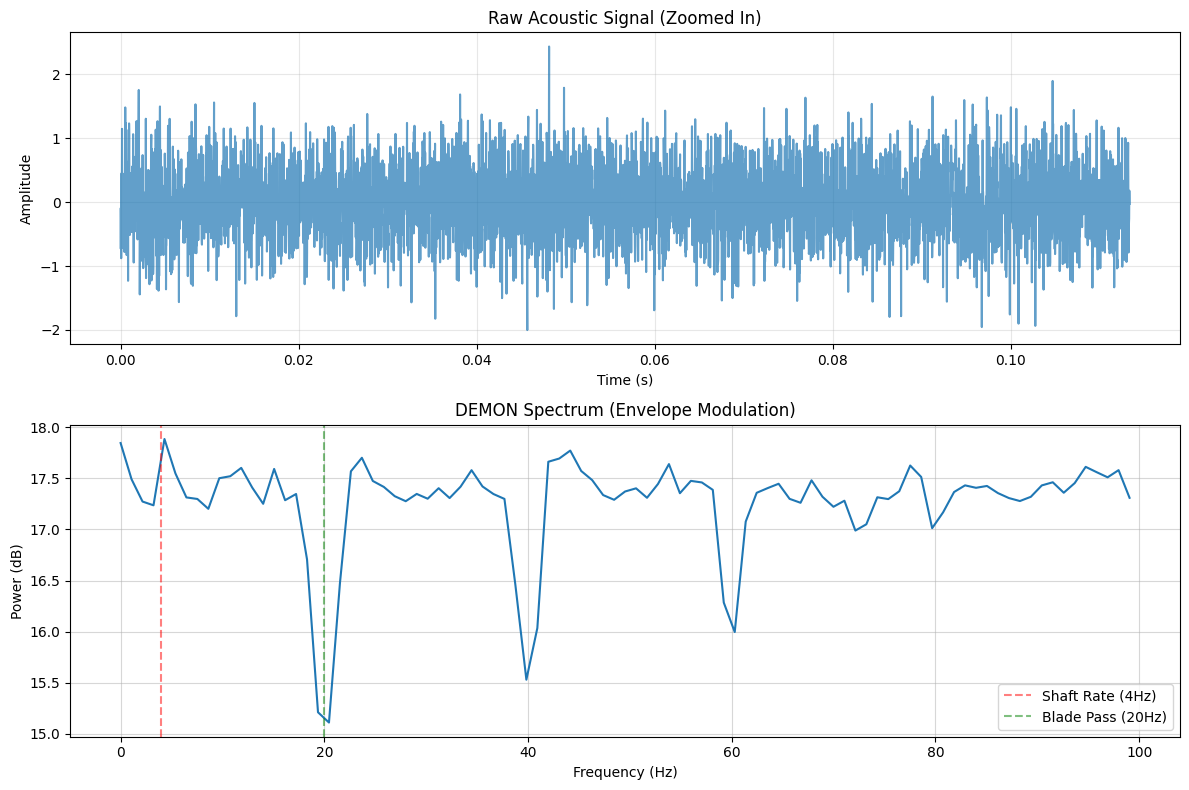

In [36]:

# --- Execution ---

# Parameters
FS = 44100 # Hydrophone sampling rate
DURATION = 5.0 # Seconds of data

# 1. Generate Data
t, raw_audio = generate_synthetic_signal(FS, DURATION)

# 2. Run DEMON Detector
freqs, demon_spectrum = robust_demon_processor(raw_audio, FS, passband=(20, 20000), decimation_factor=10)

# 3. Visualization
plt.figure(figsize=(12, 8))

# Plot Time Series
plt.subplot(2, 1, 1)
plt.plot(t[:5000], raw_audio[:5000], alpha=0.7)
plt.title("Raw Acoustic Signal (Zoomed In)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)

# Plot DEMON Spectrum
plt.subplot(2, 1, 2)
# Limit view to 0-100Hz as this is where propeller rates live
mask = freqs < 100 
plt.plot(freqs[mask], 10 * np.log10(demon_spectrum[mask]))
plt.title("DEMON Spectrum (Envelope Modulation)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid(True, which='both', alpha=0.5)

# Annotate the expected peaks
# Based on our synthetic generation: Shaft=4Hz, Blades=5 -> Blade Pass=20Hz
plt.axvline(x=4, color='r', linestyle='--', alpha=0.5, label='Shaft Rate (4Hz)')
plt.axvline(x=20, color='g', linestyle='--', alpha=0.5, label='Blade Pass (20Hz)')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
names, fss, all_data, recommended_slices = ut.load_ds_samples()

Data dicts: 
names=['dpv1', 'dpv2', 'croatia_ship', 'bg_noise']
fss keys=['dpv1', 'dpv2', 'croatia_ship', 'bg_noise']
all_data keys=['dpv1', 'dpv2', 'croatia_ship', 'bg_noise']
slices keys=['dpv1', 'dpv2', 'croatia_ship', 'bg_noise']


In [37]:
demons = dict()

for i, name in enumerate(names):
    data = all_data[name]
    fs = fss[name]
    freqs, demon_spectrum = robust_demon_processor(data, fs, passband=(20, 20000), decimation_factor=10)
    demons[name] = demon_spectrum

fig = make_subplots(rows=len(names), shared_xaxes=True, vertical_spacing=0.02)
for i, name in enumerate(names):
    fig.add_trace(go.Scatter(x=freqs, y=demons[name], mode='lines', name=f'DEMON Spectrum - {name}'), row=i+1, col=1)

fig.update_layout(title='DEMON Spectra for Various Samples', height=300*len(names), width=800)
fig.update_xaxes(title_text='Frequency (Hz)', row=len(names), col=1)
fig.update_yaxes(title_text='Power (dB)')
fig.show()